## Context

This notebook validates a single hypothesis using a fully audited, canonical dataset.

Data:
- NYC 311 complaints (Brooklyn, Noise – Residential, 2023)
- Hourly weather data from NOAA ISD, station KJFK (744860-94789)

Data contracts:
- Complaint timestamps are NYC local time (naive)
- Weather timestamps are NYC local time (naive), derived from UTC with DST handled upstream
- Weather is station-specific (KJFK) and geographically valid for Brooklyn
- Merge between complaints and weather is validated (m:1 by local hour)
- Weather coverage is ~99.9% after merge

Hypothesis:
Residential noise complaints increase with temperature,
but only during evening and night hours.


In [9]:
import pandas as pd

df = pd.read_pickle("data/nyc311_noise_brooklyn_2023_with_weather_canonical.pkl")

print("rows:", len(df))
display(df.head(3))
display(df.dtypes)
print("temperature_c null rate:", float(df["temperature_c"].isna().mean()))


rows: 86040


,created_hour,temperature_c,complaint_id
0,2023-01-01,8.9,56418136
1,2023-01-01,8.9,56413156
2,2023-01-01,8.9,56417885


created_hour     datetime64[us]
temperature_c           float64
complaint_id             string
dtype: object

temperature_c null rate: 0.0009646675964667597


In [10]:
df = df.copy()

df["hour"] = df["created_hour"].dt.hour

def assign_time_bucket(hour: int) -> str:
    if 8 <= hour <= 17:
        return "Day"
    elif 18 <= hour <= 22:
        return "Evening"
    else:
        return "Night"

df["time_bucket"] = df["hour"].apply(assign_time_bucket)

display(df[["created_hour", "hour", "time_bucket", "temperature_c"]].head(5))


,created_hour,hour,time_bucket,temperature_c
0,2023-01-01,0,Night,8.9
1,2023-01-01,0,Night,8.9
2,2023-01-01,0,Night,8.9
3,2023-01-01,0,Night,8.9
4,2023-01-01,0,Night,8.9


In [11]:
BIN_SIZE = 3  # °C

df["temp_bin"] = ((df["temperature_c"] // BIN_SIZE) * BIN_SIZE).astype("Int64")

agg = (
    df
    .dropna(subset=["temp_bin"])
    .groupby(["time_bucket", "temp_bin"])
    .agg(complaints_count=("complaint_id", "count"))
    .reset_index()
    .sort_values(["time_bucket", "temp_bin"])
)

display(agg.head(15))


,time_bucket,temp_bin,complaints_count
0,Day,-15,6
1,Day,-12,8
2,Day,-9,64
3,Day,-6,36
4,Day,-3,112
5,Day,0,722
6,Day,3,2093
7,Day,6,2572
8,Day,9,2889
9,Day,12,1660


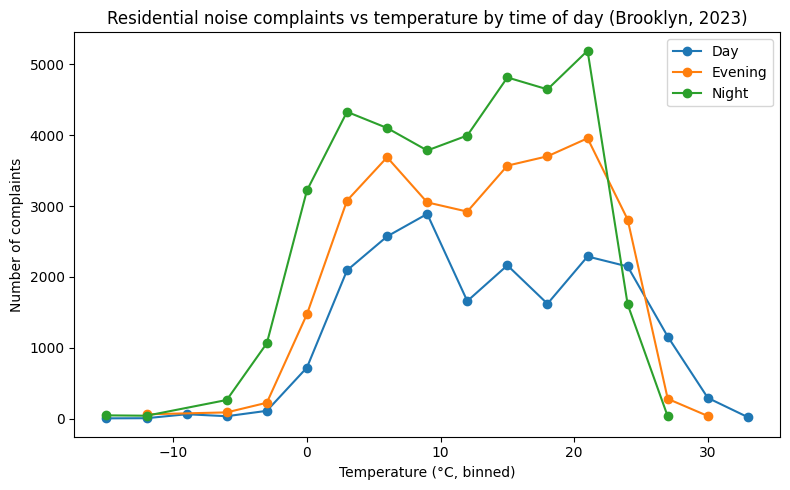

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for bucket in ["Day", "Evening", "Night"]:
    sub = agg[agg["time_bucket"] == bucket]
    plt.plot(sub["temp_bin"], sub["complaints_count"], marker="o", label=bucket)

plt.xlabel("Temperature (°C, binned)")
plt.ylabel("Number of complaints")
plt.title("Residential noise complaints vs temperature by time of day (Brooklyn, 2023)")
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion

The hypothesis is supported by the data.

Residential noise complaints in Brooklyn do not increase meaningfully with temperature during daytime hours.
However, a clear and consistent increase appears during evening and night hours.

This pattern suggests that temperature alone is not sufficient to explain noise complaints.
The effect emerges only when higher temperatures intersect with specific human activity periods
(evening and night), indicating a strong interaction between environmental conditions and behavior.

No causal claims are made.
The result relies on a geographically valid, time-consistent data contract.
